# Detect Demand Peaks

> In this example we will show how to perform electricity load forecasting on the ERCOT (Texas) market for detecting daily peaks.

## Introduction

Predicting peaks in different markets is useful. In the electricity market, consuming electricity at peak demand is penalized with higher tarifs. When an individual or company consumes electricity when its most demanded, regulators calls that a coincident peak (CP).

In the Texas electricity market (ERCOT), the peak is the monthly 15-minute interval when the ERCOT Grid is at a point of highest capacity. The peak is caused by all consumers’ combined demand on the electrical grid. The coincident peak demand is an important factor used by ERCOT to determine final electricity consumption bills. ERCOT registers the CP demand of each client for 4 months, between June and September, and uses this to adjust electricity prices. Clients can therefore save on electricity bills by reducing the coincident peak demand.

In this example we will train an `MSTL` (Multiple Seasonal-Trend decomposition using LOESS) model on historic load data to forecast day-ahead peaks on September 2022. Multiple seasonality is traditionally present in low sampled electricity data. Demand exhibits daily and weekly seasonality, with clear patterns for specific hours of the day such as 6:00pm vs 3:00am or for specific days such as Sunday vs Friday.

First, we will load ERCOT historic demand, then we will use the `StatsForecast.cross_validation` method to fit the MSTL model and forecast daily load during September. Finally, we show how to use the forecasts to detect the coincident peak. 

**Outline**

1. Install libraries
1. Load and explore the data
1. Fit MSTL model and forecast
1. Peak detection

:::{.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/docs/tutorials/ElectricityPeakForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
:::


## Libraries

We assume you have StatsForecast already installed. Check this guide for instructions on [how to install StatsForecast](../getting-started/0_Installation).

Install the necessary packages using `pip install statsforecast`

## Load Data

The input to StatsForecast is always a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds` and `y`:

* The `unique_id` (string, int or category) represents an identifier for the series. 

* The `ds` (datestamp or int) column should be either an integer indexing time or a datestamp ideally like YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
Y_df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/ERCOT-clean.csv', parse_dates=['ds'])

Plot the series using the `plot` method from the `StatsForecast` class. This method prints up to 8 random series from the dataset and is useful for basic EDA.

:::{.callout-note}
The `StatsForecast.plot` method uses Plotly as a default engine. You can change to MatPlotLib by setting `engine="matplotlib"`.
 
:::

In [ ]:
from statsforecast import StatsForecast

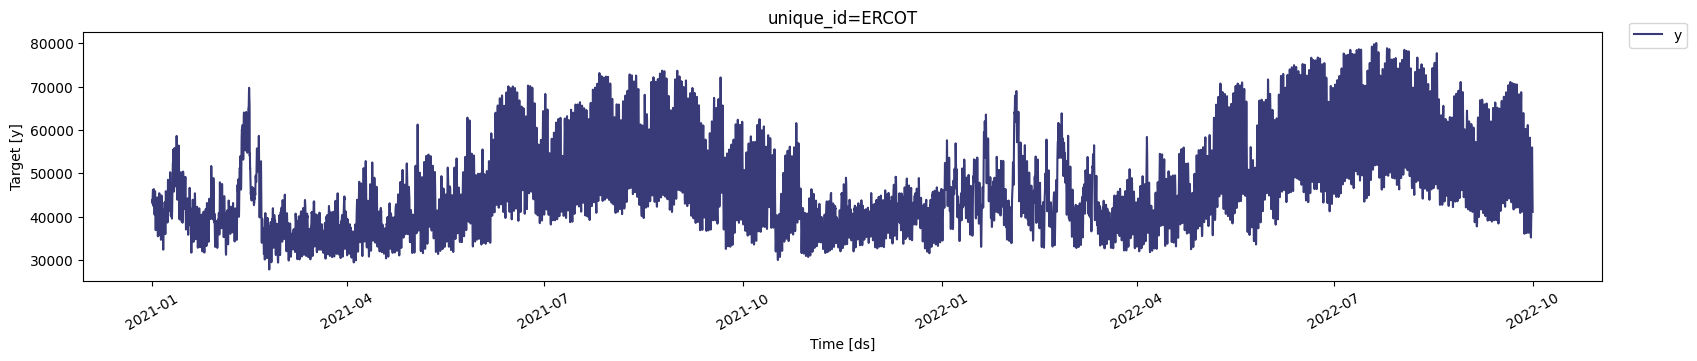

In [ ]:
StatsForecast.plot(Y_df)

We observe that the time series exhibits seasonal patterns. Moreover, the time series contains `6,552` observations, so it is necessary to use computationally efficient methods to deploy them in production.

## Fit and Forecast MSTL model

The MSTL (Multiple Seasonal-Trend decomposition using LOESS) model decomposes the time series in multiple seasonalities using a Local Polynomial Regression (LOESS). Then it forecasts the trend using a custom non-seasonal model and each seasonality using a SeasonalNaive model.

:::{.callout-tip}
Check our detailed explanation and tutorial on MSTL [here](../tutorials/MultipleSeasonalities)
:::

Import the `StatsForecast` class and the models you need. 

In [ ]:
from sklearn.linear_model import LinearRegression
from utilsforecast.feature_engineering import trend

from statsforecast import StatsForecast
from statsforecast.models import MSTL, SklearnModel

First, instantiate the model and define the parameters. The electricity load presents seasonalities every 24 hours (Hourly) and every 24 * 7 (Daily) hours. Therefore, we will use `[24, 24 * 7]` as the seasonalities. See [this link](https://robjhyndman.com/hyndsight/seasonal-periods/) for a detailed explanation on how to set seasonal lengths. In this example we use the `SklearnModel` with a `LinearRegression` model for the trend component, however, any StatsForecast model can be used. The complete list of models is available [here](../../models).

In [ ]:
train, _ = trend(Y_df, freq='H')
train.head()

,unique_id,ds,y,trend
0,ERCOT,2021-01-01 00:00:00,43719.849616,1.0
1,ERCOT,2021-01-01 01:00:00,43321.050347,2.0
2,ERCOT,2021-01-01 02:00:00,43063.067063,3.0
3,ERCOT,2021-01-01 03:00:00,43090.059203,4.0
4,ERCOT,2021-01-01 04:00:00,43486.590073,5.0


In [ ]:
models = [
    MSTL(
        season_length=[24, 24 * 7], # seasonalities of the time series
        trend_forecaster=SklearnModel(LinearRegression()) # model used to forecast trend
    )
]

We fit the model by instantiating a `StatsForecast` object with the following required parameters:

* `models`: a list of models. Select the models you want from [models](../../models) and import them.

* `freq`: a string indicating the frequency of the data. (See [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

In [ ]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(
    models=models,
    freq='H',
)

:::{.callout-tip}
StatsForecast also supports this optional parameter.

* `n_jobs`: n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores. (Default: 1)

* `fallback_model`: a model to be used if a model fails. (Default: none)

:::

The `cross_validation` method allows the user to simulate multiple historic forecasts, greatly simplifying pipelines by replacing for loops with `fit` and `predict` methods. This method re-trains the model and forecast each window. See [this tutorial](../getting-started/2_Getting_Started_complete) for an animation of how the windows are defined. 

Use the `cross_validation` method to produce all the daily forecasts for September. To produce daily forecasts set the forecasting horizon `h` as 24. In this example we are simulating deploying the pipeline during September, so set the number of windows as 30 (one for each day). Finally, set the step size between windows as 24, to only produce one forecast per day.

In [ ]:
cv_df = sf.cross_validation(
    df=train,
    h=24,
    step_size=24,
    n_windows=30
  )

In [ ]:
cv_df.head()

,unique_id,ds,cutoff,y,MSTL
0,ERCOT,2022-09-01 00:00:00,2022-08-31 23:00:00,45482.471757,47413.944185
1,ERCOT,2022-09-01 01:00:00,2022-08-31 23:00:00,43602.658043,45237.153285
2,ERCOT,2022-09-01 02:00:00,2022-08-31 23:00:00,42284.817342,43816.390019
3,ERCOT,2022-09-01 03:00:00,2022-08-31 23:00:00,41663.156771,42972.956286
4,ERCOT,2022-09-01 04:00:00,2022-08-31 23:00:00,41710.621904,42909.899438


:::{.callout-important}
When using `cross_validation` make sure the forecasts are produced at the desired timestamps. Check the `cutoff` column which specifices the last timestamp before the forecasting window.
:::

## Peak Detection

Finally, we use the forecasts in `cv_df` to detect the daily hourly demand peaks. For each day, we set the detected peaks as the highest forecasts. In this case, we want to predict one peak (`npeaks`); depending on your setting and goals, this parameter might change. For example, the number of peaks can correspond to how many hours a battery can be discharged to reduce demand.

In [ ]:
npeaks = 1 # Number of peaks

For the ERCOT 4CP detection task we are interested in correctly predicting the highest monthly load. Next, we filter the day in September with the highest hourly demand and predict the peak.

In [ ]:
cv_df = cv_df[['ds','y','MSTL']]
max_day = cv_df.iloc[cv_df['y'].argmax()].ds.day # Day with maximum load
cv_df_day = cv_df.query('ds.dt.day == @max_day')
max_hour = cv_df_day['y'].argmax()
peaks = cv_df_day['MSTL'].argsort().iloc[-npeaks:].values # Predicted peaks

In the following plot we see how the MSTL model is able to correctly detect the coincident peak for September 2022.

In [ ]:
import matplotlib.pyplot as plt

<matplotlib.legend.Legend>

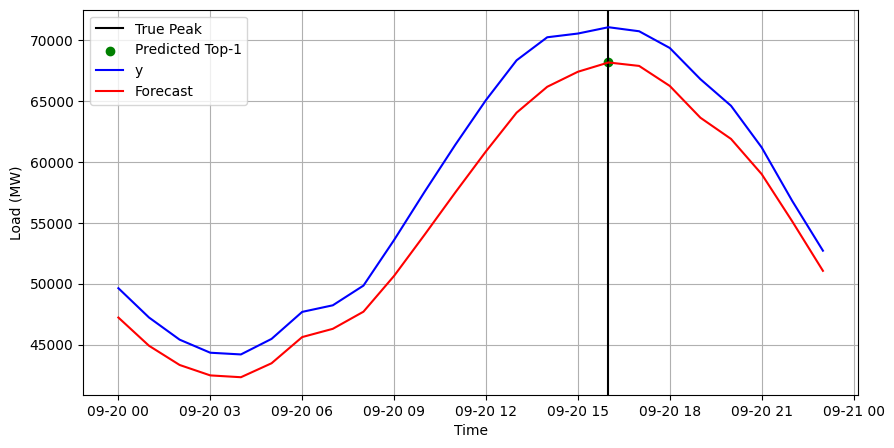

In [ ]:
plt.figure(figsize=(10, 5))
plt.axvline(cv_df_day.iloc[max_hour]['ds'], color='black', label='True Peak')
plt.scatter(cv_df_day.iloc[peaks]['ds'], cv_df_day.iloc[peaks]['MSTL'], color='green', label=f'Predicted Top-{npeaks}')
plt.plot(cv_df_day['ds'], cv_df_day['y'], label='y', color='blue')
plt.plot(cv_df_day['ds'], cv_df_day['MSTL'], label='Forecast', color='red')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.grid()
plt.legend()

:::{.callout-important}
In this example we only include September. However, MSTL can correctly predict the peaks for the 4 months of 2022. You can try this by increasing the `nwindows` parameter of `cross_validation` or filtering the `Y_df` dataset. The complete run for all months take only 10 minutes.
:::

## Next steps

StatsForecast and MSTL in particular are good benchmarking models for peak detection. However, it might be useful to explore further and newer forecasting algorithms. We have seen particularly good results with the N-HiTS, a deep-learning model from Nixtla's NeuralForecast library.

Learn how to predict ERCOT demand peaks with our deep-learning N-HiTS model and the NeuralForecast library in [this tutorial](../../../neuralforecast/use-cases/electricitypeakforecasting).

## References

- [Bandara, Kasun & Hyndman, Rob & Bergmeir, Christoph. (2021). “MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with Multiple Seasonal Patterns”](https://arxiv.org/abs/2107.13462).
- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). "N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting". Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)